In [2]:
from stereo_matching import *
import cv2
import numpy as np
import matplotlib.pyplot as plt

(np.float64(-0.5), np.float64(809.5), np.float64(349.5), np.float64(-0.5))

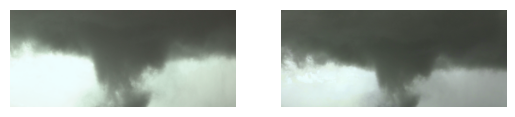

In [6]:
imgL = cv2.imread('../data/color_matched/Schyma_4K_calibrated_81705.png')
imgR = cv2.imread('../data/color_matched/Seimon_4K_calibrated_2024_corrected_81705.png')

imgL = imgL[100:1500, 600:]
imgR = imgR[100:1500, :3240]
imgL = imgL[::4, ::4]
imgR = imgR[::4, ::4]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(imgL, cmap='gray')
axs[0].axis('off')
axs[1].imshow(imgR, cmap='gray')
axs[1].axis('off')

In [7]:
cv2.imwrite('schyma_cropped.png', imgL)
cv2.imwrite('seimon_cropped.png', imgR)

True

In [22]:
left_features = select_features(imgL)

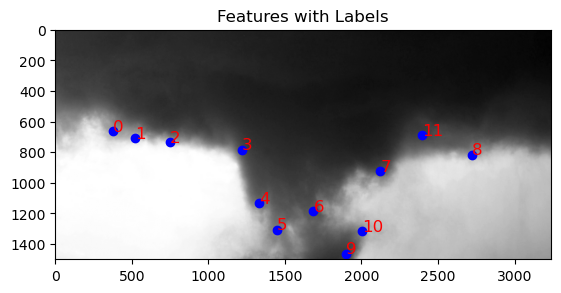

In [23]:
for i, pt in enumerate(left_features):
    plt.scatter(pt[0], pt[1], color='blue')
    plt.text(pt[0], pt[1], str(i), color='red', fontsize=12)
    
plt.imshow(imgL, cmap='gray')
plt.title('Features with Labels')
plt.show()

In [25]:
right_features = select_features(imgR)

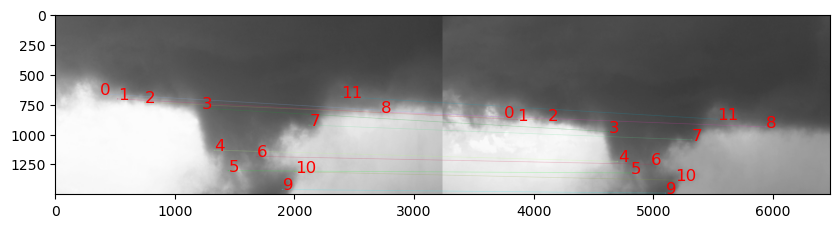

In [28]:
# Convert points to numpy arrays
pts1 = np.array(left_features)
pts2 = np.array(right_features)

# Draw the matches between the images
img_matches = cv2.drawMatches(imgL, [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in pts1], 
                              imgR, [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in pts2], 
                              [cv2.DMatch(i, i, 0) for i in range(len(pts1))], None)

draw_matches(imgL, imgR, pts1, pts2)


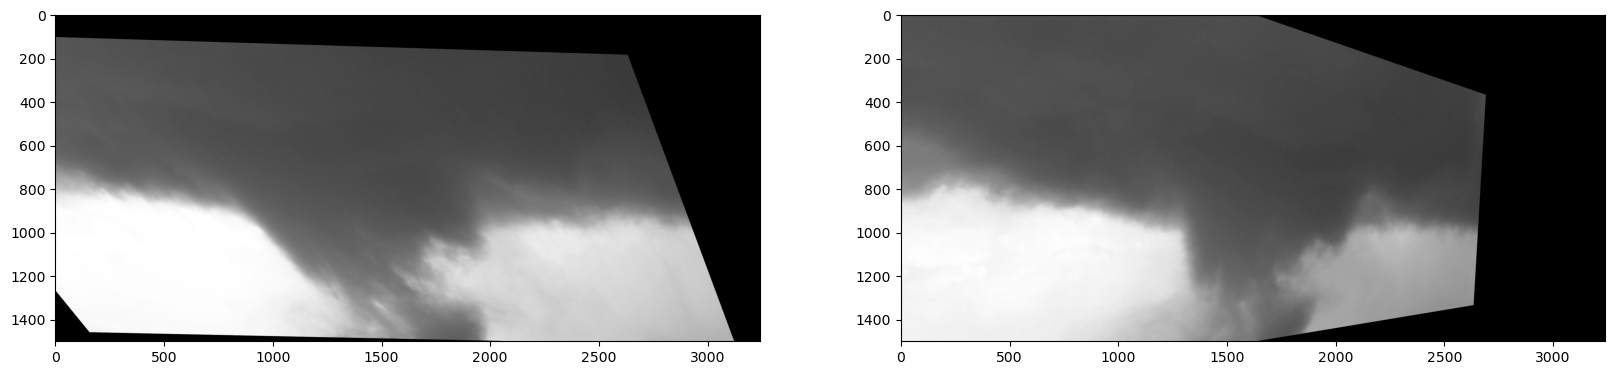

In [29]:
F, inliers = cv2.findFundamentalMat(
            np.float32(pts1),
            np.float32(pts2),
            method=cv2.RANSAC,
            ransacReprojThreshold=3,
            confidence=0.7
        )
h1, w1 = imgL.shape
h2, w2 = imgR.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1), threshold=3,
)

imgL_undistorted = cv2.warpPerspective(imgL, H1, (w1, h1))
imgR_undistorted = cv2.warpPerspective(imgR, H2, (w2, h2))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(imgL_undistorted, cmap='gray')
axs[1].imshow(imgR_undistorted, cmap='gray')

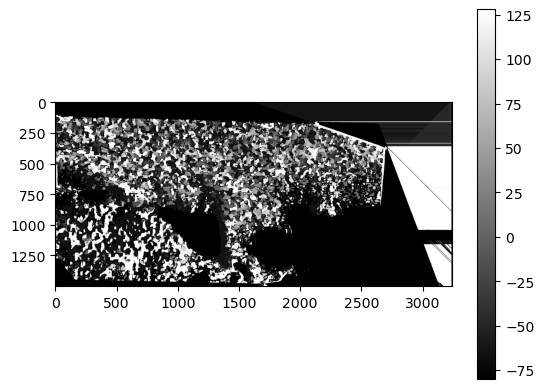

In [31]:
# Using StereoSGBM
# Set disparity parameters. Note: disparity range is tuned according to
#  specific parameters obtained through trial and error.
win_size = 2
min_disp = -4
max_disp = 9
num_disp = max_disp - min_disp  # Needs to be divisible by 16
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=25,
    uniquenessRatio=5,
    speckleWindowSize=5,
    speckleRange=5,
    disp12MaxDiff=2,
    P1=8 * 3 * win_size ** 2,
    P2=32 * 3 * win_size ** 2,
)

disparity_SGBM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_SGBM, "gray")
plt.colorbar()
plt.show()